generate data set for llama factory first. tusimple json format is:

```
{"raw_file": "clips/0531/.../20.jpg", "lanes": [[-2, 500, 510, ...], [600, 610, ..., -2]], "h_samples": [300, 310, 320, ...]}
```

final sharegpt style sft format:

```
{
  "images": ["path/to/image.jpg"],
  "messages": [
    {
      "role": "user",
      "content": "<image>\\nDetect all lane lines. Output each lane as a list of (x, y) coordinates in JSON format."
    },
    {
      "role": "assistant",
      "content": "{\\n  \\\"lanes\\\": [\\n    [{\\\"x\\\": 500, \\\"y\\\": 310}, {\\\"x\\\": 510, \\\"y\\\": 320}],\\n    ...\\n  ]\\n}"
    }
  ]
}
```

llama factory dataset转换脚本：

In [2]:
import json
import os
from pathlib import Path

def convert_tusimple_to_llamafactory(
    tusimple_root: str,
    output_json_path: str,
    split: str = "train"
):
    label_files = []
    if split == "train":
        label_files = [
            "label_data_0313.json",
            "label_data_0601.json",
            "label_data_0531.json"
        ]
    else:
        label_files = ["test_tasks_0627.json"]

    dataset = []

    for label_file in label_files:
        with open(os.path.join(tusimple_root, label_file), 'r') as f:
            for line in f:
                data = json.loads(line.strip())
                img_path = os.path.join(tusimple_root, data["raw_file"])
                if not os.path.exists(img_path):
                    continue

                h_samples = data["h_samples"]
                lanes = data["lanes"]

                # 构建车道线坐标列表
                lane_coords = []
                for lane in lanes:
                    coords = []
                    for x, y in zip(lane, h_samples):
                        if x >= 0:  # 有效点
                            coords.append({"x": int(x), "y": int(y)})
                    if coords:
                        lane_coords.append(coords)

                # 构造 Llama Factory 格式
                output_dict = {"lanes": lane_coords}
                output_str = json.dumps(output_dict, indent=2)

                sample = {
                    "images": [img_path],
                    "messages": [
                        {
                            "role": "user",
                            "content": "<image>\nDetect all lane lines. Output each lane as a list of (x, y) coordinates in JSON format."
                        },
                        {
                            "role": "assistant",
                            "content": output_str
                        }
                    ]
                }
                dataset.append(sample)

    # 保存到本地 JSON
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(dataset, f, indent=2, ensure_ascii=False)

    print(f"✅ Saved {len(dataset)} samples to {output_json_path}")


if __name__ == "__main__":
    TUSIMPLE_ROOT = "/media/zzcc/file/aigc/llm/datasets/TUSimple/train_set/"  # 替换为你的路径
    OUTPUT_JSON = "./tusimple_llamafactory.json"
    convert_tusimple_to_llamafactory(TUSIMPLE_ROOT, OUTPUT_JSON, split="train")

✅ Saved 3626 samples to ./tusimple_llamafactory.json


testing: preview one original image and drive lane.

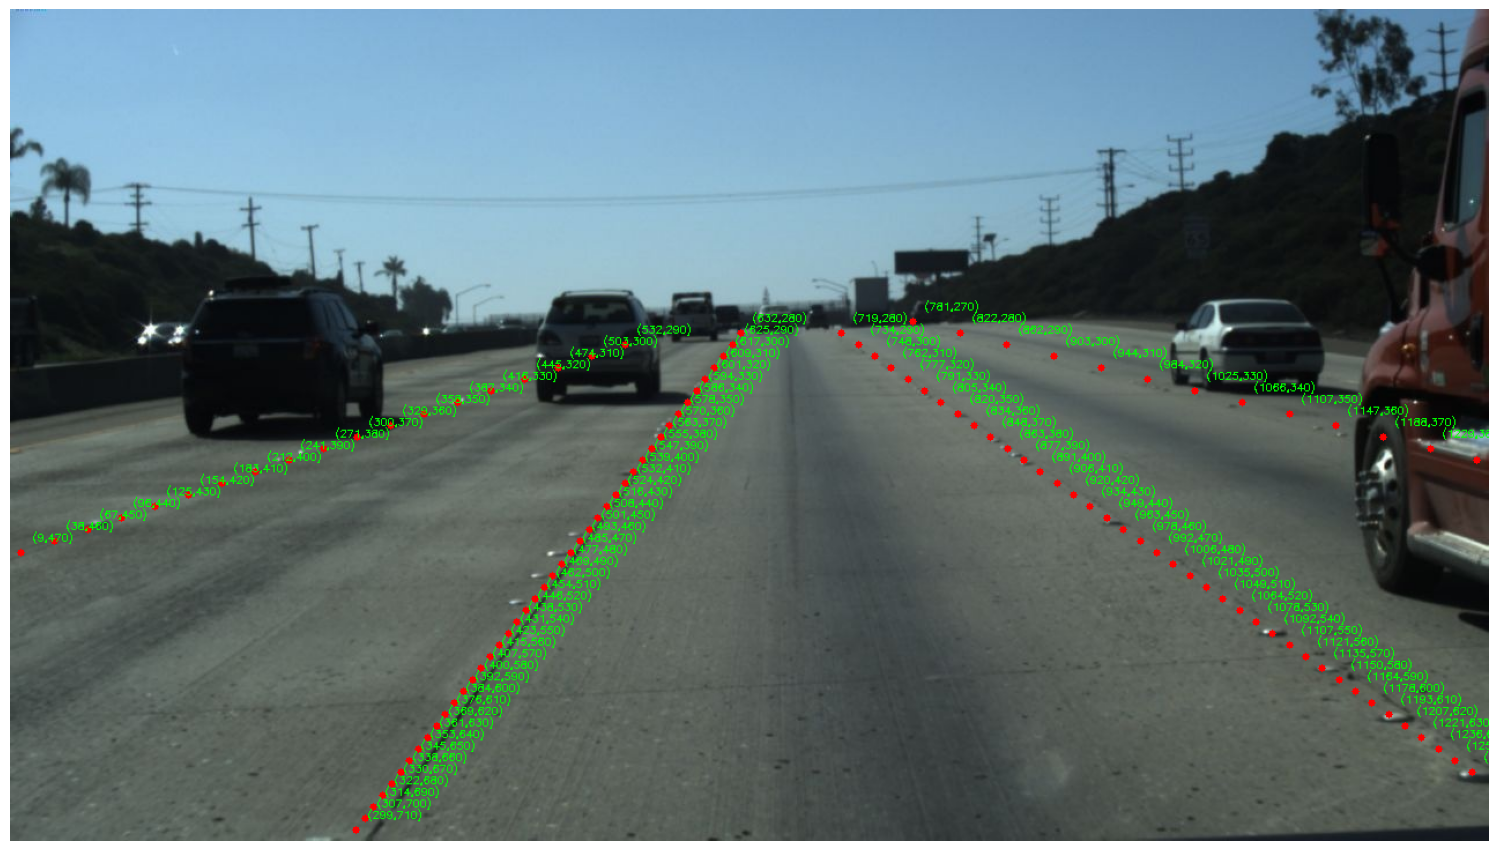

In [ ]:
with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)
first_obj = data[0]
#print(json.dumps(first_obj, indent=2, ensure_ascii=False))

# read image 
import cv2
image = cv2.imread(first_obj['images'][0])

extracted_lanes = json.loads(first_obj['messages'][1]['content'])['lanes']
#print(extracted_lanes)
for lane in extracted_lanes:
    for point in lane:
        cv2.circle(image, (point['x'], point['y']), 3, (0, 0, 255), -1)
        # 在点旁边添加坐标文本
        x = point['x']
        y = point['y']
        text = f'({x},{y})'
        cv2.putText(image, text, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)  # 绿色文字

# cv2.imshow('image', image)
# cv2.waitKey(0)

import matplotlib.pyplot as plt
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1920/100 , 1920/100 * image.shape[0]/image.shape[1]))
plt.imshow(rgb_image)
plt.axis('off')  # 不显示坐标轴
plt.show()


move tusimple_llamafactory.json to llma factory dir

In [17]:
LLaMA_Factory_DIR = "/media/zzcc/file/aigc/llm/LLaMA-Factory"
!cp tusimple_llamafactory.json $LLaMA_Factory_DIR/data

revise data info

In [18]:
# backup old json
!cp $LLaMA_Factory_DIR/data/dataset_info.json $LLaMA_Factory_DIR/data/dataset_info.json.bk

revise data info and add a new tusimple_llamafactory.json

In [21]:
data_path = os.path.join(LLaMA_Factory_DIR, 'data/dataset_info.json')
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
    data['tusimple_llamafactory'] = {
        "file_name": "tusimple_llamafactory.json",
        "formatting": "sharegpt",
        "columns": {
        "messages": "messages",
        "images": "images"
        },
        "tags": {
        "role_tag": "role",
        "content_tag": "content",
        "user_tag": "user",
        "assistant_tag": "assistant"
        }
    }

with open(data_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=2, ensure_ascii=False)


training params

In [ ]:
!cd $LLaMA_Factory_DIR

!llamafactory-cli train \
    --stage sft \
    --do_train True \
    --model_name_or_path /media/zzcc/file/aigc/llm/models/Qwen/Qwen2___5-VL-3B-Instruct/ \
    --preprocessing_num_workers 16 \
    --finetuning_type lora \
    --template qwen2_vl \
    --flash_attn auto \
    --dataset_dir data \
    --dataset tusimple_llamafactory \
    --cutoff_len 2048 \
    --learning_rate 5e-05 \
    --num_train_epochs 2.0 \
    --max_samples 100000 \
    --per_device_train_batch_size 1 \
    --gradient_accumulation_steps 16 \
    --lr_scheduler_type cosine \
    --max_grad_norm 1.0 \
    --logging_steps 5 \
    --save_steps 100 \
    --warmup_steps 0 \
    --packing False \
    --enable_thinking True \
    --report_to none \
    --output_dir saves/Qwen2.5-VL-3B-Instruct/lora/train_2025-10-08-20-31-15 \
    --bf16 True \
    --plot_loss True \
    --trust_remote_code True \
    --ddp_timeout 180000000 \
    --include_num_input_tokens_seen True \
    --optim adamw_torch \
    --lora_rank 8 \
    --lora_alpha 16 \
    --lora_dropout 0 \
    --lora_target all \
    --freeze_vision_tower True \
    --freeze_multi_modal_projector True \
    --image_max_pixels 589824 \
    --image_min_pixels 1024 \
    --video_max_pixels 65536 \

# Validation

[{'x': 578, 'y': 280}, {'x': 589, 'y': 290}, {'x': 600, 'y': 300}, {'x': 611, 'y': 310}, {'x': 622, 'y': 320}, {'x': 633, 'y': 330}, {'x': 644, 'y': 340}, {'x': 655, 'y': 350}, {'x': 666, 'y': 360}, {'x': 677, 'y': 370}, {'x': 688, 'y': 380}, {'x': 699, 'y': 390}, {'x': 710, 'y': 400}, {'x': 721, 'y': 410}, {'x': 732, 'y': 420}, {'x': 743, 'y': 430}, {'x': 754, 'y': 440}, {'x': 765, 'y': 450}, {'x': 776, 'y': 460}, {'x': 787, 'y': 470}, {'x': 798, 'y': 480}, {'x': 809, 'y': 490}, {'x': 820, 'y': 500}, {'x': 831, 'y': 510}, {'x': 842, 'y': 520}, {'x': 853, 'y': 530}, {'x': 864, 'y': 540}, {'x': 875, 'y': 550}, {'x': 886, 'y': 560}, {'x': 897, 'y': 570}, {'x': 908, 'y': 580}, {'x': 919, 'y': 590}, {'x': 930, 'y': 600}, {'x': 941, 'y': 610}, {'x': 952, 'y': 620}, {'x': 963, 'y': 630}, {'x': 974, 'y': 640}, {'x': 985, 'y': 650}, {'x': 996, 'y': 660}, {'x': 1007, 'y': 670}, {'x': 1018, 'y': 680}, {'x': 1029, 'y': 690}, {'x': 1040, 'y': 700}, {'x': 1051, 'y': 710}]
[{'x': 647, 'y': 280}, {'x

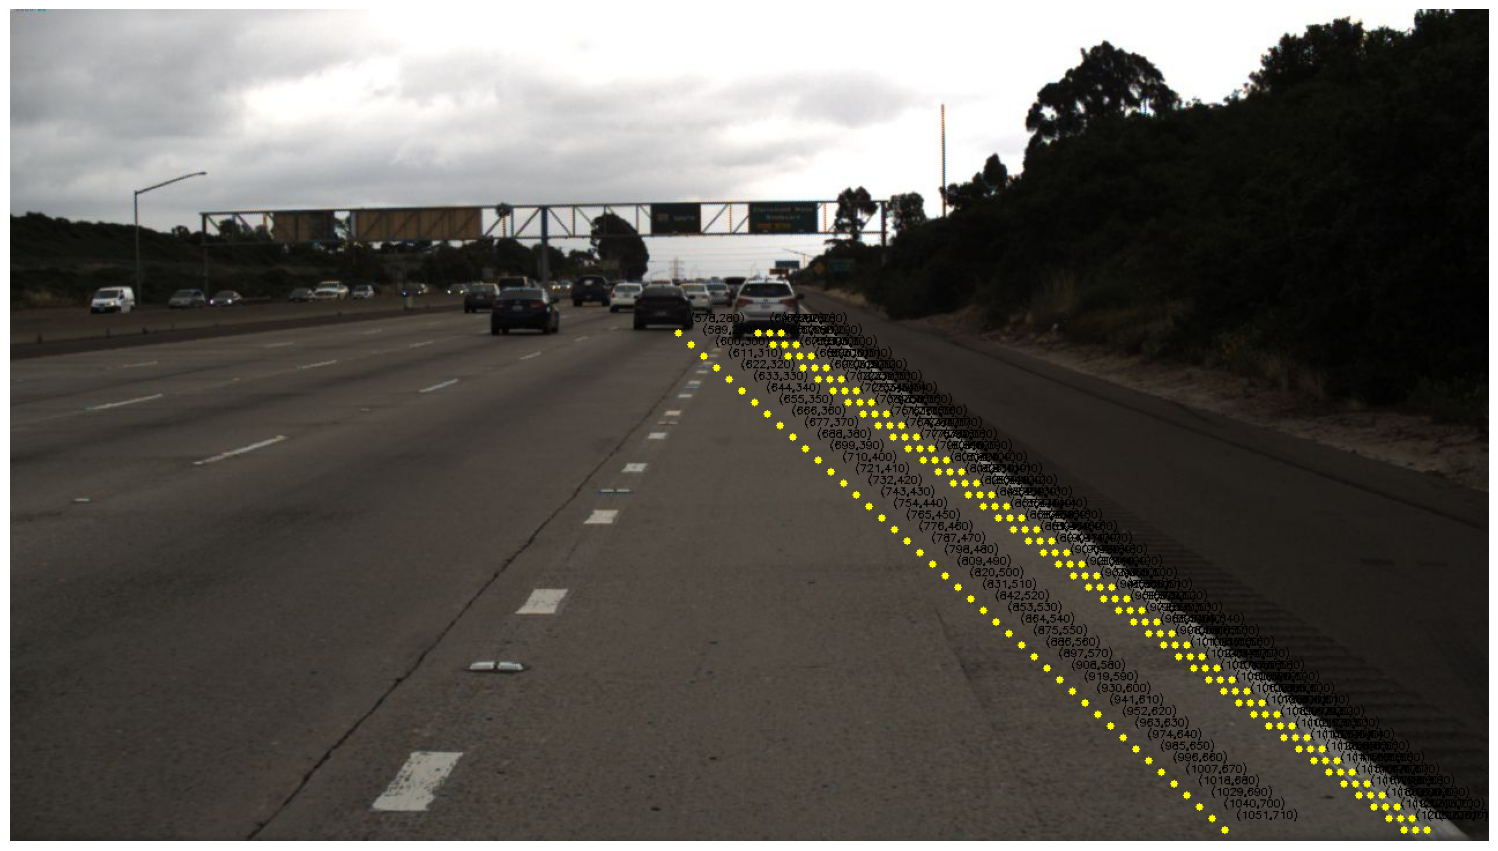

In [15]:
import json
import cv2

import cv2
image = cv2.imread('10.jpg')

with open('test_json.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    lanes = data['lanes']
    for lane in lanes:
        print(lane)
        for point in lane:
            cv2.circle(image, (point['x'], point['y']), 3, (0, 255, 255), -1)
            # 在点旁边添加坐标文本
            x = point['x']
            y = point['y']
            text = f'({x},{y})'
            cv2.putText(image, text, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)  # 绿色文字

# cv2.imshow('image', image)
# cv2.waitKey(0)

import matplotlib.pyplot as plt
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1920/100 , 1920/100 * image.shape[0]/image.shape[1]))
plt.imshow(rgb_image)
plt.axis('off')  # 不显示坐标轴
plt.show()

# Chat

Use webUI for chat and picture comparation.